In [1]:
%load_ext autoreload

In [30]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
verbose = False
agent_data = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
    
    areas = ['all']
    agent_data[(data_class, agent)] = {'session_list': session_list}

    session_lists, locs, rocs, ropaps = get_session_plot_info(cfg, session_list, verbose=False)

    agent_data[(data_class, agent)]['session_lists'] = session_lists
    agent_data[(data_class, agent)]['locs'] = locs
    agent_data[(data_class, agent)]['rocs'] = rocs
    agent_data[(data_class, agent)]['ropaps'] = ropaps

    noise_filter_info = get_noise_filter_info(cfg, session_list, verbose=verbose)
    agent_data[(data_class, agent)]['noise_filter_info'] = noise_filter_info
    
    pca_chosen = get_pca_chosen(cfg, session_list, areas, noise_filter_info, verbose=verbose)
    agent_data[(data_class, agent)]['pca_chosen'] = pca_chosen
    all_indices_to_run = collect_grid_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    if all_indices_to_run:
        raise ValueError(f"Sessions for agent {agent} have incomplete grid search - cannot continue")
    
    grid_params_to_use = get_grid_params_to_use(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    agent_data[(data_class, agent)]['grid_params_to_use'] = grid_params_to_use
    all_indices_to_run = collect_delase_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, grid_params_to_use, verbose=verbose)
    
    if all_indices_to_run:
        raise ValueError(f"Sessions for agent {agent} have incomplete DeLASE - cannot continue")

    delase_results = get_delase_results(cfg, session_list, areas, grid_params_to_use, pca_chosen, verbose=verbose)
    agent_data[(data_class, agent)]['delase_results'] = delase_results

  0%|          | 0/3 [00:00<?, ?it/s]

Only 0 valid windows could be found for section 'awake lever1' with times [np.float64(-36.23385444444445), np.float64(-26.050830555555557)]
Only 3 valid windows could be found for section 'early unconscious' with times [np.float64(26.003301111111107), 45]
Only 3 valid windows could be found for section 'awake lever1' with times [np.float64(-36.10079944444445), np.float64(-26.03974944444445)]
Only 0 valid windows could be found for section 'awake lever2' with times [np.float64(-10.029036111111115), 0]
Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]


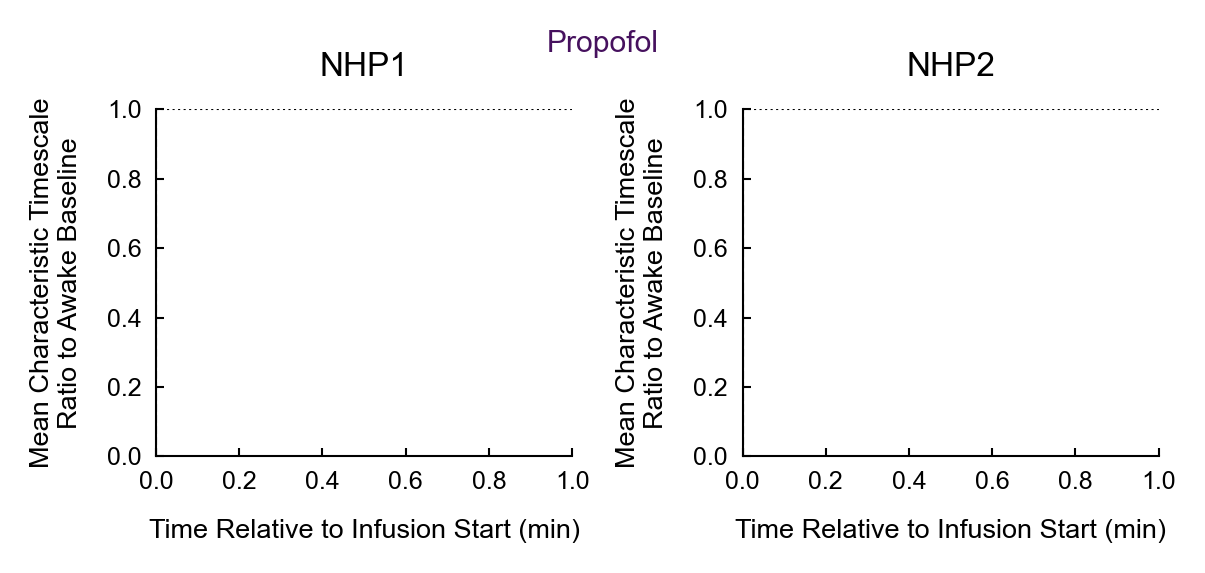

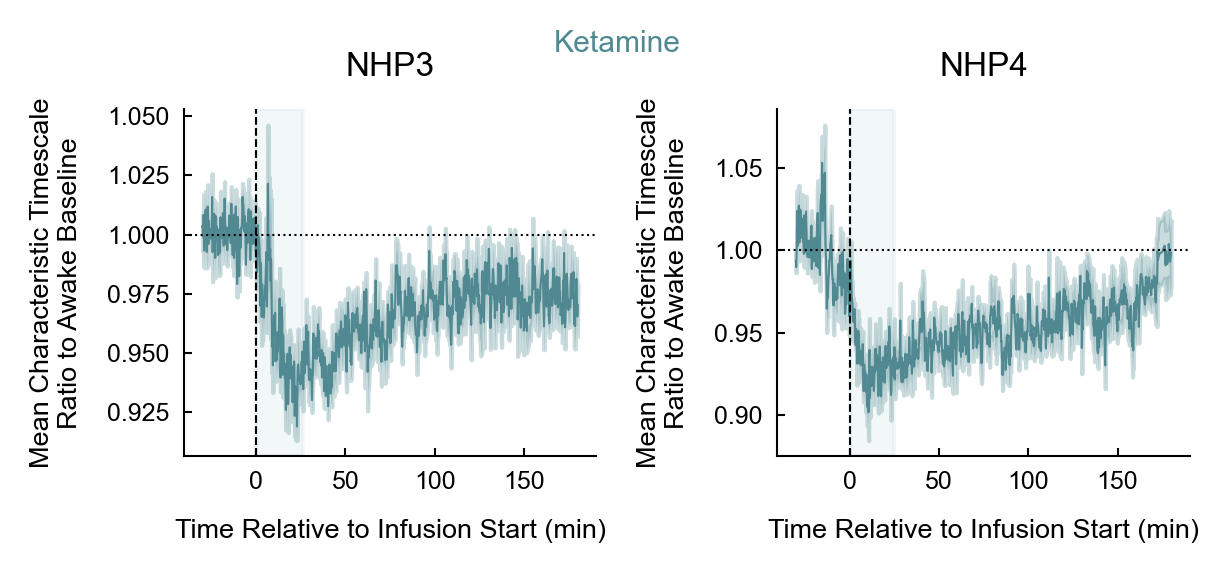

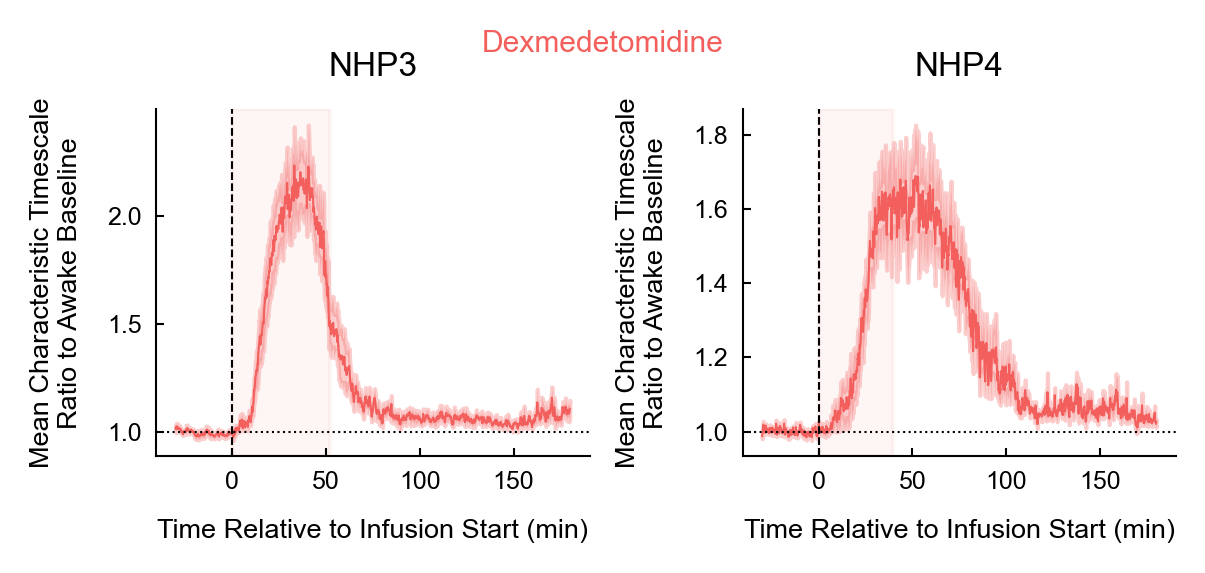

In [7]:
for (data_class, agent), data_dict in agent_data.items():
    cfg.params.data_class = data_class
    plot_session_timescales_grouped(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        data_dict['locs'], 
        data_dict['rocs'], 
        data_dict['ropaps'],
        plot_range=(-15, 85) if agent == 'propofol' else (-30, 180), 
        top_percent=0.1, 
        curve_colors=curve_colors, 
        loc_roc_colors=loc_roc_colors, 
        figsize=(4, 2),
        dose='low',
        save_path=os.path.join(img_save_dir, f"{agent}_lowdose_timescales_grouped.pdf"),
        verbose=True
    )


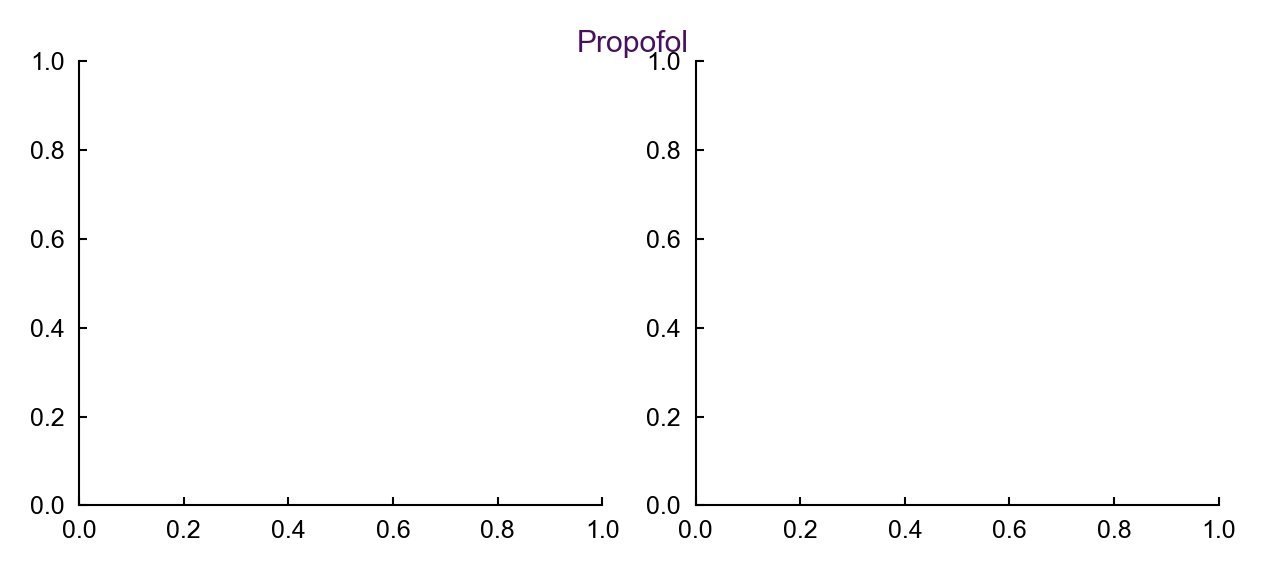

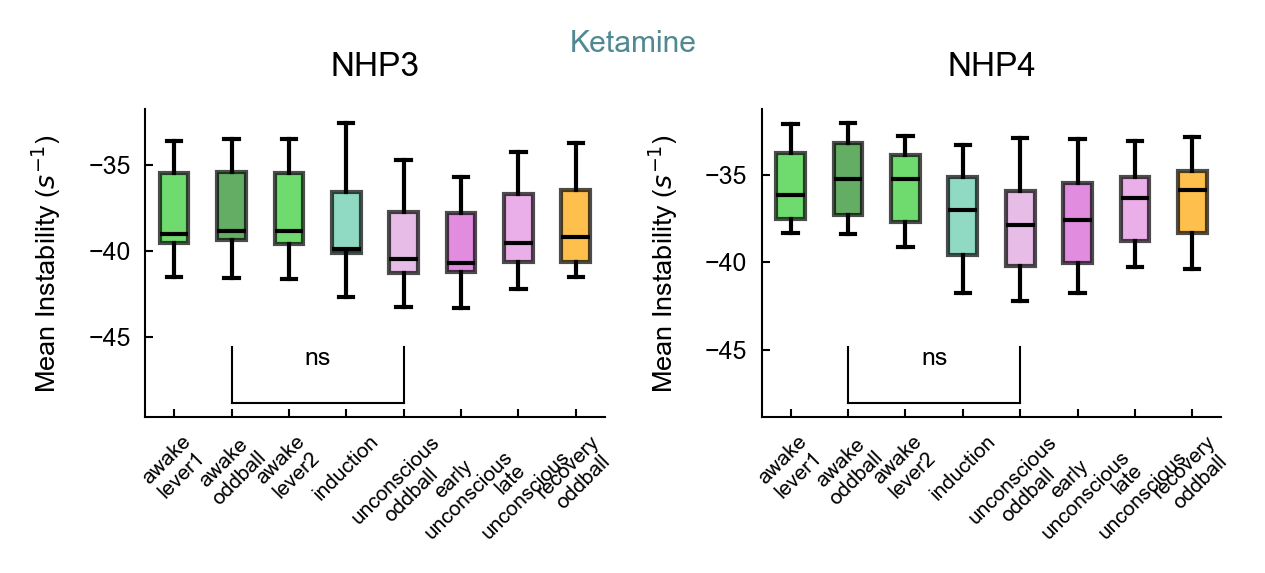

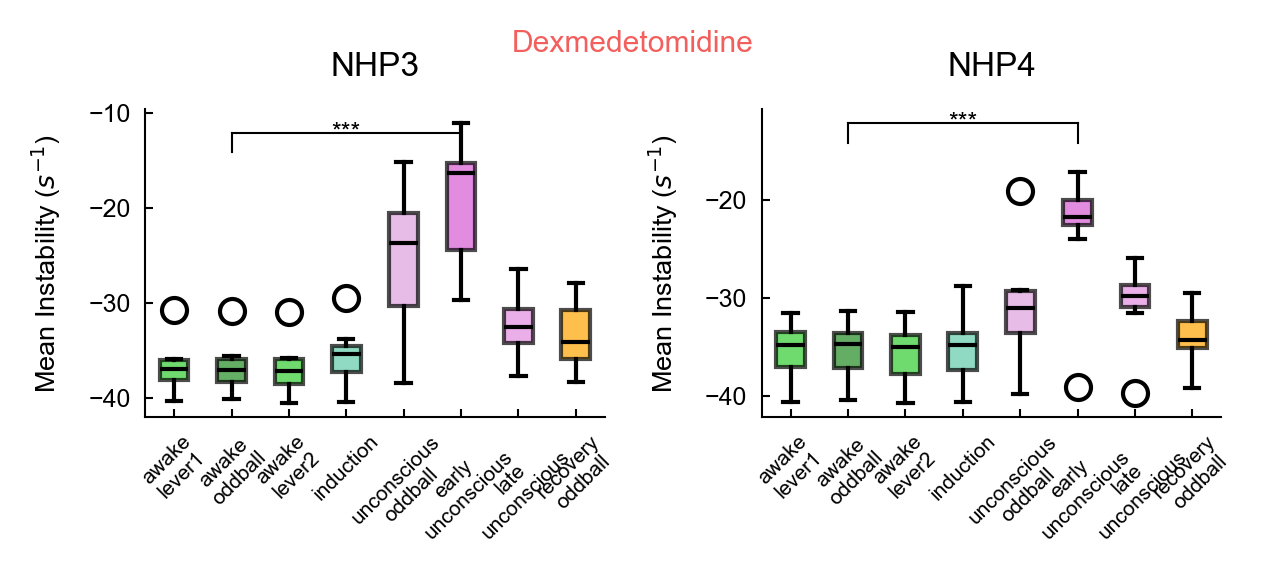

: 

In [69]:

for (data_class, agent), data_dict in agent_data.items():
    cfg.params.data_class = data_class
    plot_section_stability_boxes(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        top_percent=0.1,
        curve_colors=curve_colors,
        figsize=None,
        dose='low',
        # save_path=None,
        save_path=os.path.join(img_save_dir, f"{agent}_lowdose_section_stability_boxes.pdf"),
        verbose=False
    )

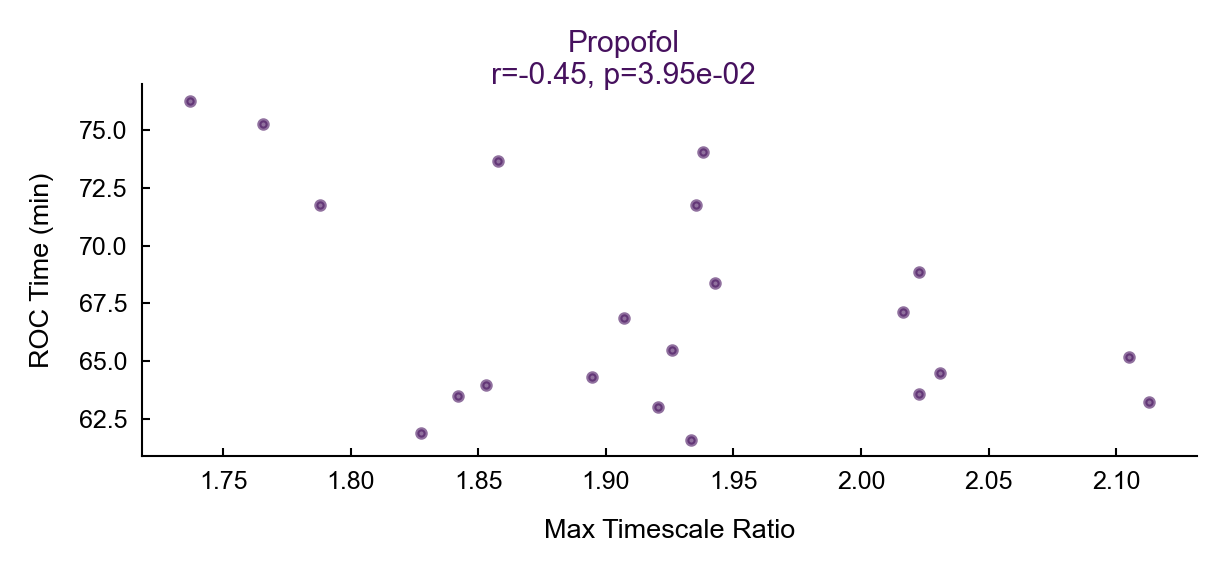

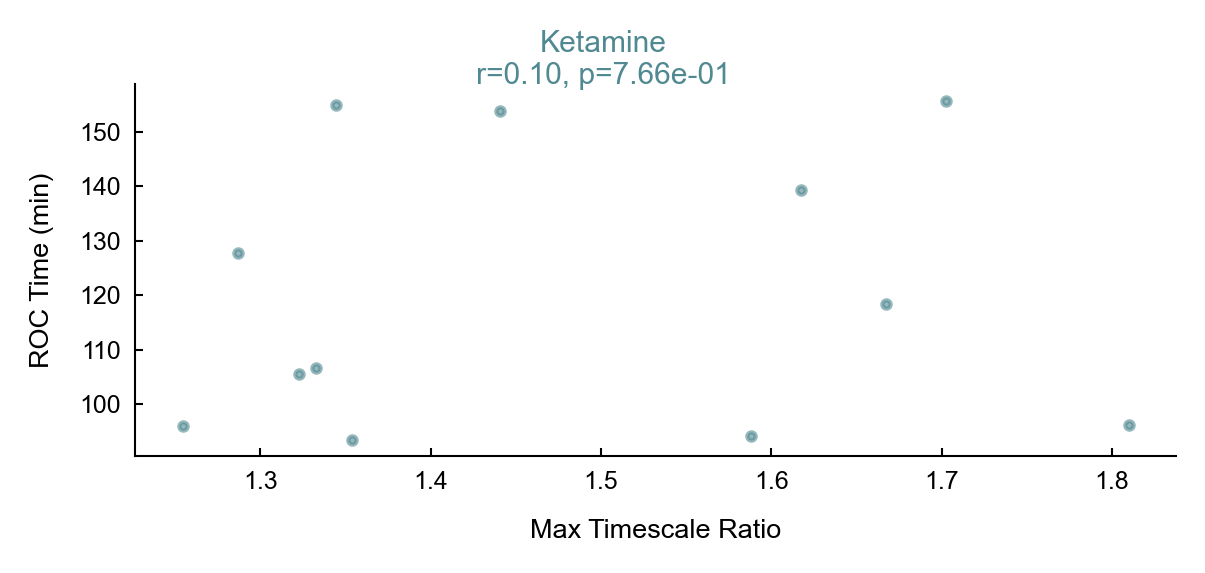

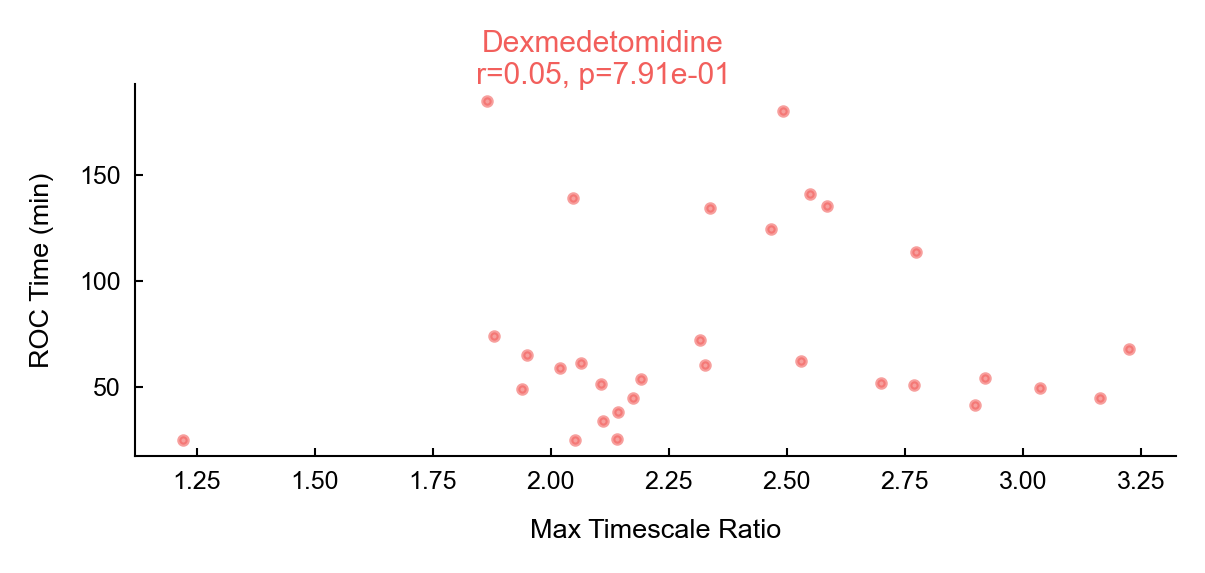

In [64]:
for (data_class, agent), data_dict in agent_data.items():
    cfg.params.data_class = data_class
    plot_roc_vs_max_timescale(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        data_dict['locs'], 
        data_dict['rocs'], 
        data_dict['ropaps'], 
        top_percent=0.1, 
        curve_colors=curve_colors, 
        figsize=(4, 2), 
        dose='high' if agent == 'ketamine' else None,
        save_path=os.path.join(img_save_dir, f"{agent}_lowdose_roc_vs_max_timescale.pdf"), 
        verbose=False
    )
